In [133]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Data input and cleaning

In [134]:
import re
sns.set()
data = pd.read_csv("data.csv", dtype={'time':np.float64})

data['error'] = [float(x[1:-1]) for x in data['fbest']]

def sanitize(data):
    return ''.join(filter(lambda x: x in ',.0123456789', data))

data['history'] = data['fhistorybk'].apply(sanitize)
data['frac'] = data['sol'].str.count("1")/40

data = data.join(data['freq'].str.split(', ', expand=True).apply(pd.to_numeric))

data.drop(["fbest", "freq", "Unnamed: 0", "fhistory", "fhistorybk"], axis=1, inplace=True)
    
data.rename(columns=lambda x: x+1 if type(x)==int else x, inplace=True)

data.head()

,crossover,errorLimit,f1,grad,nPop,sol,time,error,history,frac,1,2,3,4,5,6
0,ModalSixPoint,0.01,25,100,40,0000011110010100010001001110000000010100,3612.647007,20.587492,"39.57248833,39.57248833,39.57248833,31.2823356...",0.325,27.365016,114.545041,201.098490,323.479671,464.829225,566.837206
1,ModalSixPoint,0.01,25,150,40,1001000011111110111001000100011001000110,3620.806533,33.296211,"48.92024943,48.92024943,48.92024943,48.9202494...",0.475,30.095535,141.152401,298.646479,417.326719,677.768384,820.623475
2,ModalSixPoint,0.01,25,200,40,1001111100001111111011101110011001100111,3608.695041,56.205200,"76.41390649,75.38765492,75.38765492,75.3876549...",0.650,32.751415,156.967590,349.280381,433.227707,865.847652,1025.222357
3,ModalSixPoint,0.01,25,250,40,0000111111111111111111111111010101010000,3635.406163,83.148506,"95.68365885,95.68365885,95.68365885,95.6836588...",0.700,26.597205,125.926978,360.405270,373.073479,913.941492,1121.792865
4,ModalSixPoint,0.01,50,100,40,1000110011100001001001100100000000001010,3616.894119,19.574048,"48.68711473,40.77969395,34.96045323,34.9604532...",0.325,47.733003,146.157150,215.867735,363.607990,483.898506,604.380078


In [135]:
errors = data.drop(['crossover', 'errorLimit', 'nPop', 'sol', 'time', 'history', 'frac'], axis=1)
errors.drop([x for x in errors.columns if type(x)==int], axis=1, inplace=True)
mean_errors = errors.groupby(["f1", "grad"], as_index=False).mean()
mean_errors

,f1,grad,error
0,25,100,22.276397
1,25,150,34.455868
2,25,200,57.780923
3,25,250,76.895442
4,50,100,19.183326
5,50,150,18.381885
6,50,200,29.796874
7,50,250,41.507969
8,75,100,33.050528
9,75,150,13.134267


In [136]:
mean_errors = mean_errors.pivot("f1", "grad", "error")
mean_errors

grad,100,150,200,250
f1,,,,
25,22.276397,34.455868,57.780923,76.895442
50,19.183326,18.381885,29.796874,41.507969
75,33.050528,13.134267,19.337990,28.534573


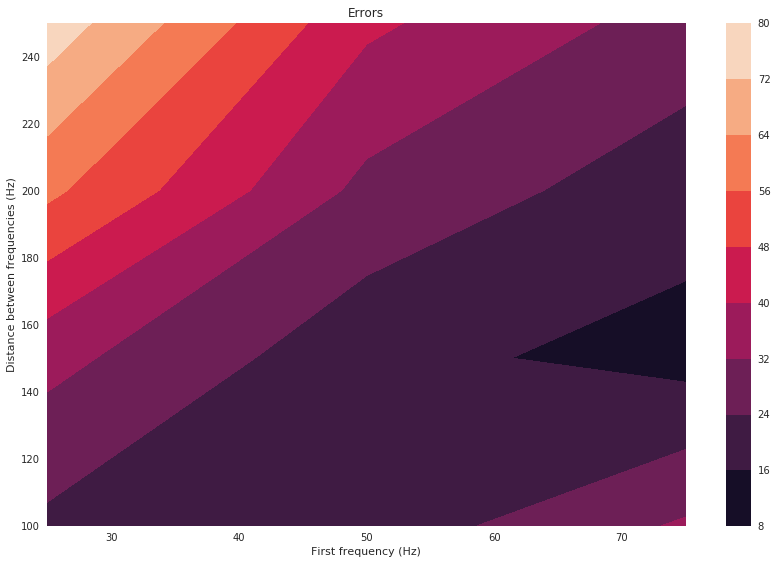

In [137]:
plt.figure(figsize=(12,8))

x = mean_errors.columns.values
y = mean_errors.index.values
Z = mean_errors.values
Y ,X = np.meshgrid(x, y)
CS = plt.contourf(X, Y, Z)
plt.xlabel("First frequency (Hz)")
plt.ylabel("Distance between frequencies (Hz)")
plt.title("Errors")
plt.colorbar()

plt.tight_layout()
plt.show()

In [138]:
E1 = 3.45e9
E0 = 115e6

p1 = 2950
p0 = 1072.5

L = 0.1

errors_nd = data.drop(['crossover', 'errorLimit', 'nPop', 'sol', 'time', 'history'], axis=1)
errors_nd.drop([x for x in errors_nd.columns if type(x)==int], axis=1, inplace=True)
factor = np.sqrt(((E1 - E0) * np.mean(errors_nd['frac']) + E0) / ((p1 - p0) * np.mean(errors_nd['frac']) + p0)) / L
errors_nd['f1'] = errors_nd['f1'] / factor
errors_nd['grad'] = errors_nd['grad'] / factor

errors_nd = errors_nd.drop(['frac'], axis=1)
mean_errors_nd = errors_nd.groupby(["f1", "grad"], as_index=False).mean()
mean_errors_nd = mean_errors_nd.pivot("f1", "grad", "error")

mean_errors_nd.head()

grad,0.010470510112836057,0.015705765169254086,0.020941020225672114,0.026176275282090145
f1,,,,
0.002618,22.276397,34.455868,57.780923,76.895442
0.005235,19.183326,18.381885,29.796874,41.507969
0.007853,33.050528,13.134267,19.337990,28.534573


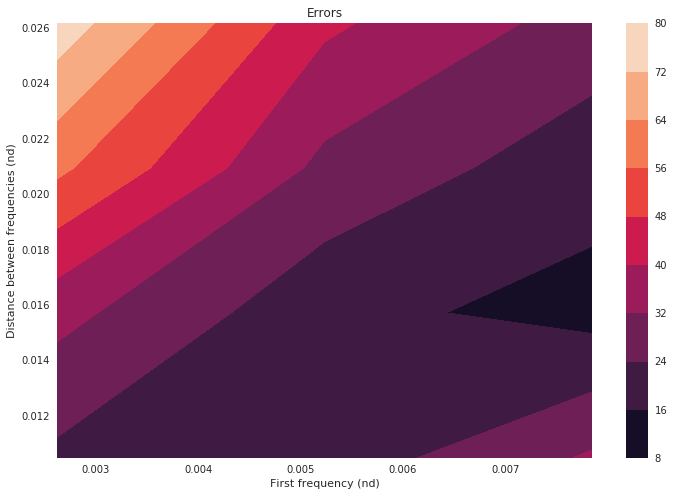

In [139]:
plt.figure(figsize=(12,8))

x = mean_errors_nd.columns.values
y = mean_errors_nd.index.values
Z = mean_errors_nd.values
Y ,X = np.meshgrid(x, y)
CS = plt.contourf(X, Y, Z)
plt.xlabel("First frequency (nd)")
plt.ylabel("Distance between frequencies (nd)")
plt.title("Errors")
plt.colorbar()
plt.show()

In [146]:
history = data.drop(['crossover', 'errorLimit', 'nPop', 'sol', 'time', 'frac', 'error'], axis=1)
history.drop([x for x in history.columns if type(x)==int], axis=1, inplace=True)
history = pd.concat([history, history['history'].str.split(',', expand=True).apply(pd.to_numeric)], axis=1)
history.drop(["history"], axis=1, inplace=True)
history.head()

,f1,grad,0,1,2,3,4,5,6,7,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,25,100,39.572488,39.572488,39.572488,31.282336,31.282336,31.282336,31.282336,31.282336,...,20.587492,20.587492,20.587492,20.587492,20.587492,20.587492,20.587492,20.587492,20.587492,20.587492
1,25,150,48.920249,48.920249,48.920249,48.920249,48.920249,46.175262,46.175262,46.175262,...,33.296211,33.296211,33.296211,33.296211,33.296211,33.296211,33.296211,33.296211,33.296211,33.296211
2,25,200,76.413906,75.387655,75.387655,75.387655,71.955492,70.895136,70.895136,70.895136,...,56.205200,56.205200,56.205200,56.205200,56.205200,56.205200,56.205200,56.205200,56.205200,56.205200
3,25,250,95.683659,95.683659,95.683659,95.683659,94.694074,94.694074,94.694074,94.538384,...,83.148506,83.148506,83.148506,83.148506,83.148506,83.148506,83.148506,83.148506,83.148506,83.148506
4,50,100,48.687115,40.779694,34.960453,34.960453,33.644744,33.644744,32.309904,32.309904,...,19.574048,19.574048,19.574048,19.574048,19.574048,19.574048,19.574048,19.574048,19.574048,19.574048


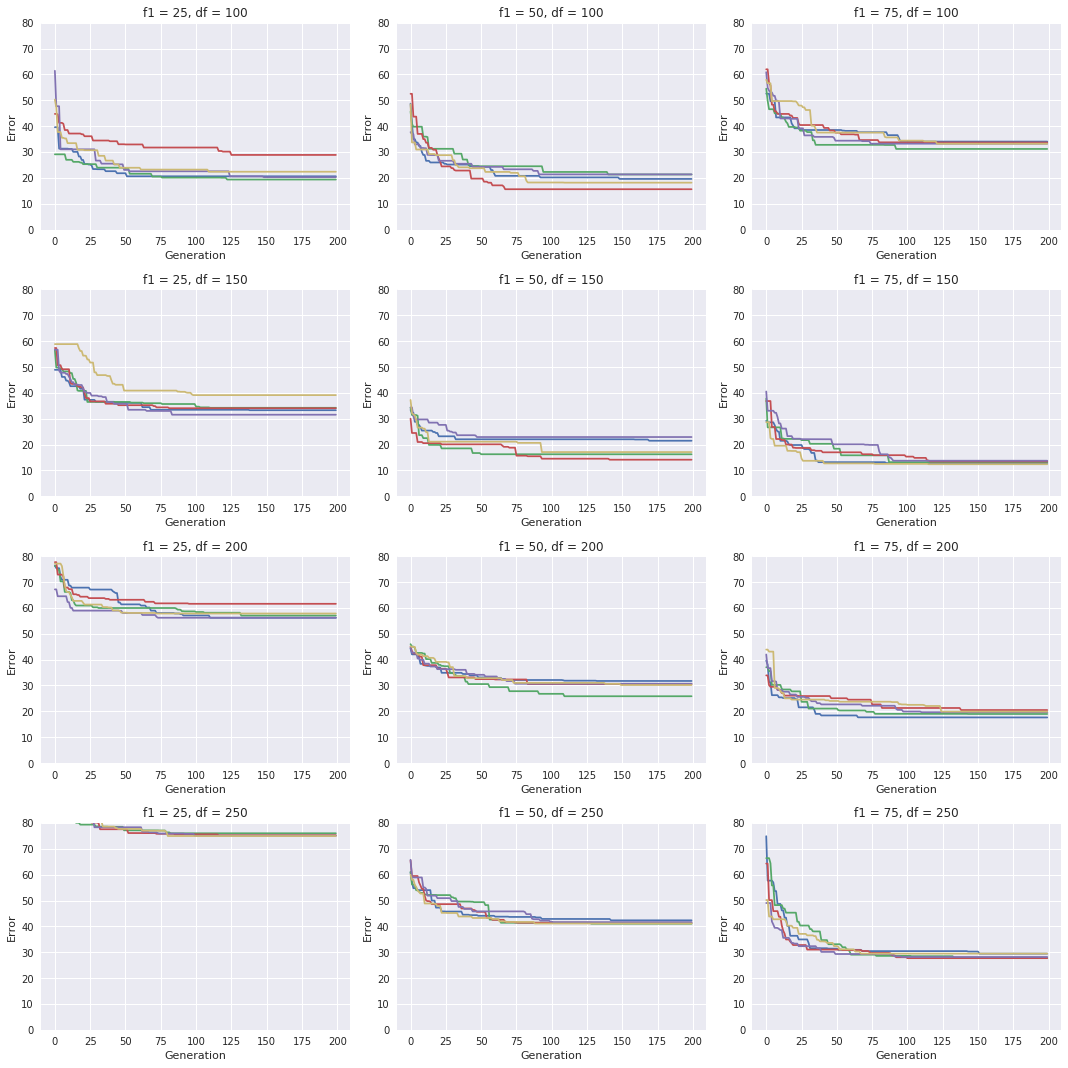

In [165]:
fig = plt.figure(figsize=(15, 15))

for i, f1 in enumerate([25, 50, 75]):
    for j, grad in enumerate([100, 150, 200, 250]):
        fig.add_subplot(4, 3, (i + 1) + (j)*3)
        f1grad = history[(history["f1"]==f1) & (history["grad"]==grad)].drop(["f1", "grad"], axis=1)
        f1grad.drop([x for x in f1grad.columns if x >=200], axis=1, inplace=True)
        f1grad = f1grad.T
        plt.title("f1 = {}, df = {}".format(f1, grad))
        plt.plot(f1grad)
        plt.ylim([0, 80])
        plt.xlabel("Generation")
        plt.ylabel("Error")

plt.tight_layout()
plt.show()
